# SmartBeds - Manifolds

## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [1]:
%matplotlib inline 
#para dibujar en el propio notebook
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #%matplotlilib.pyplot como plt
import mpl_toolkits.mplot3d #Matplotlib 3d
import pickle as pk #Pikcle as pk
import gc #Garbage colector
from sys import getsizeof

## Lectura de datos

In [2]:
datos, datos_seizure, datos_notSeizure = [None, None, None]
modo = True
save = ""
def carga(modo):
    print("--------------------Nueva Carga-------------------------")
    global datos, datos_seizure, datos_notSeizure
    if modo:
        file = 'data/datos_clean.pdd'
    else:
        file = 'data/datos_clean_stats.pdd'
    with open(file,'rb') as f:
        datos = pk.load(f)
        
    if not modo: #Se eliminan los datos "normales" (P1---PX)
        valores = ['DateTime']
        valores += [col for col in datos.columns if 'mean' in col or 'std' in col or 'range' in col]
        valores.append('target')
        datos = datos[valores]

    datos_seizure = datos.loc[datos['target']==True]
    datos_notSeizure = datos.loc[datos['target']==False]
    
    gc.collect()
    print(datos.head())
    
def carga_pre(b):
    global modo, save
    modo = True
    save = ""
    carga(modo)

def carga_est(b):
    global modo, save
    modo = False
    save = '-est'
    carga(modo)

In [3]:
import ipywidgets as widgets
from IPython.display import display

buttonPre = widgets.Button(
    description='Datos Preprocesados'
)
buttonPre.on_click(carga_pre)

buttonEst = widgets.Button(
    description='Datos estadísticos'
)
buttonEst.on_click(carga_est)

hb = widgets.HBox([buttonPre,buttonEst])
display(hb)

--------------------Nueva Carga-------------------------
                   DateTime   P1        P2        P3         P4   P5  \
5969390 2018-08-28 12:09:43  0.0  11.47541  9.016393  14.754098  0.0   
5969757 2018-08-28 12:15:56  0.0  11.47541  9.016393  15.573770  0.0   
5969790 2018-08-28 12:16:29  0.0  11.47541  9.016393  15.573770  0.0   
5969791 2018-08-28 12:16:30  0.0  11.47541  9.016393  14.754098  0.0   
5969792 2018-08-28 12:16:31  0.0  11.47541  9.016393  15.573770  0.0   

               P6  target  
5969390  7.377049   False  
5969757  7.377049   False  
5969790  7.377049   False  
5969791  7.377049   False  
5969792  7.377049   False  


## Particionado - Solo día de crisis

In [4]:
### Días donde hubo crisis
dayOfSeizures = set()

for i in datos_seizure['DateTime']:
    dayOfSeizures.add(i.date())


#Todos los datos de esos días
crit = datos['DateTime'].map(lambda x: x.date() in dayOfSeizures)

datosPart = datos[crit]
datosPart.head()
len(datosPart),getsizeof(datosPart)/2**20

(267025, 16.552590370178223)

In [5]:
dayOfSeizures

{datetime.date(2018, 11, 10),
 datetime.date(2019, 1, 29),
 datetime.date(2019, 2, 6)}

In [6]:
data = datosPart.iloc[:,1:len(datosPart.columns)-1] 
#Si el modo es False data tiene los valores de medias y estadisticas
#data = data.astype(np.float32)
print(getsizeof(data)/2**20)
data.head()

14.260696411132812


,P1,P2,P3,P4,P5,P6
4115415,0.0,19.672131,20.491803,27.868852,22.950820,12.295082
4115416,0.0,23.770492,27.868852,36.885246,29.508197,13.934426
4115417,0.0,25.409836,30.327869,38.524590,31.147541,14.754098
4115419,0.0,25.409836,27.049180,33.606557,24.590164,13.114754
4115418,0.0,27.049180,29.508197,35.245902,27.049180,13.114754


In [7]:
with open('data/datosDay'+save+'.pdd','wb') as f:
    pk.dump(datosPart,f)

## Particionado - Cuarenta minutos alrededor de los crisis

In [7]:
## datosPart tiene lo días donde hubo ataques
# Cogemos la hora donde comenzó la crisis y cogemos 30 minutos antes
# Cogemos la hora donde terminó la crisis y cogemos 30 minutos despues
start = [] #Momentos en los que comenzó una crisis
stop = [] #Momentos en los que terminó una crisis

bi = datosPart.first_valid_index()
before = datosPart['target'][bi]
for index,row in datosPart.iterrows():
    if row['target'] and not before:
        start.append(row['DateTime'])
    elif not row['target'] and before:
        stop.append(datosPart['DateTime'][bi])
    before = row['target']
    bi = index
    
halfhour = 20*60

for i in range(len(start)):
    t = start[i]
    s = stop[i]
    start[i] = t-pd.to_timedelta(halfhour,unit='s')
    stop[i] = s+pd.to_timedelta(halfhour,unit='s')

start,stop

([Timestamp('2018-11-10 03:10:00'),
  Timestamp('2019-01-29 05:52:00'),
  Timestamp('2019-02-06 21:21:00')],
 [Timestamp('2018-11-10 04:10:00'),
  Timestamp('2019-01-29 06:47:00'),
  Timestamp('2019-02-06 22:20:00')])

In [ ]:
masks = []
for i in range(len(start)):
    t = start[i]
    s = stop[i]
    masks.append(np.array([(datosPart['DateTime'] >= t) & (datosPart['DateTime'] <= s)],dtype=np.bool))

parts = []
mask=sum(masks)[0].astype(np.bool)
datosPartHour = datosPart.iloc[mask]

In [ ]:
dataPH = datosPartHour.iloc[:,1:len(datosPartHour.columns)-1]
print(getsizeof(dataPH)/2**20)
#dataPH = dataPH.astype(np.float32)
dataPH.head()

1.2857666015625


,P1,P2,P3,P4,P5,P6
4143908,4.918033,26.229508,20.491803,25.409836,25.409836,16.393443
4143909,5.737705,27.049180,20.491803,25.409836,26.229508,17.213115
4143910,5.737705,26.229508,19.672131,24.590164,25.409836,16.393443
4143911,5.737705,27.049180,20.491803,25.409836,26.229508,17.213115
4143912,5.737705,26.229508,19.672131,24.590164,25.409836,16.393443


In [11]:
with open('data/datos20Min'+save+'.pdd','wb') as f:
    pk.dump(datosPartHour,f)

##### Valores estadítiscos

In [15]:
from loadData import normalize

if not modo:
    dataPH_mean     = normalize(dataPH[[x for x in dataPH.columns if 'mean' in x]])*100
    dataPH_std      = normalize(dataPH[[x for x in dataPH.columns if 'std' in x]])*100
    dataPH_range    = normalize(dataPH[[x for x in dataPH.columns if 'range' in x]])*100
    dataPH_mean_std = pd.concat([dataPH_mean, dataPH_std],axis=1)
    dataPH          = pd.concat([dataPH_mean, dataPH_std, dataPH_range],axis=1)

## SpectralEmbedding

In [11]:
from sklearn.manifold import SpectralEmbedding as SE

### Datos brutos

In [15]:
seB = SE(n_components=2,n_neighbors=50).fit_transform(dataPH) #Con 50 vecinos no peta

In [ ]:
with open('data/spectalEmbedding.npy','wb') as f:
    pk.dump(seB,f)

Text(0.5, 1.0, 'Spectral Embedding Raw - Days of seizures')

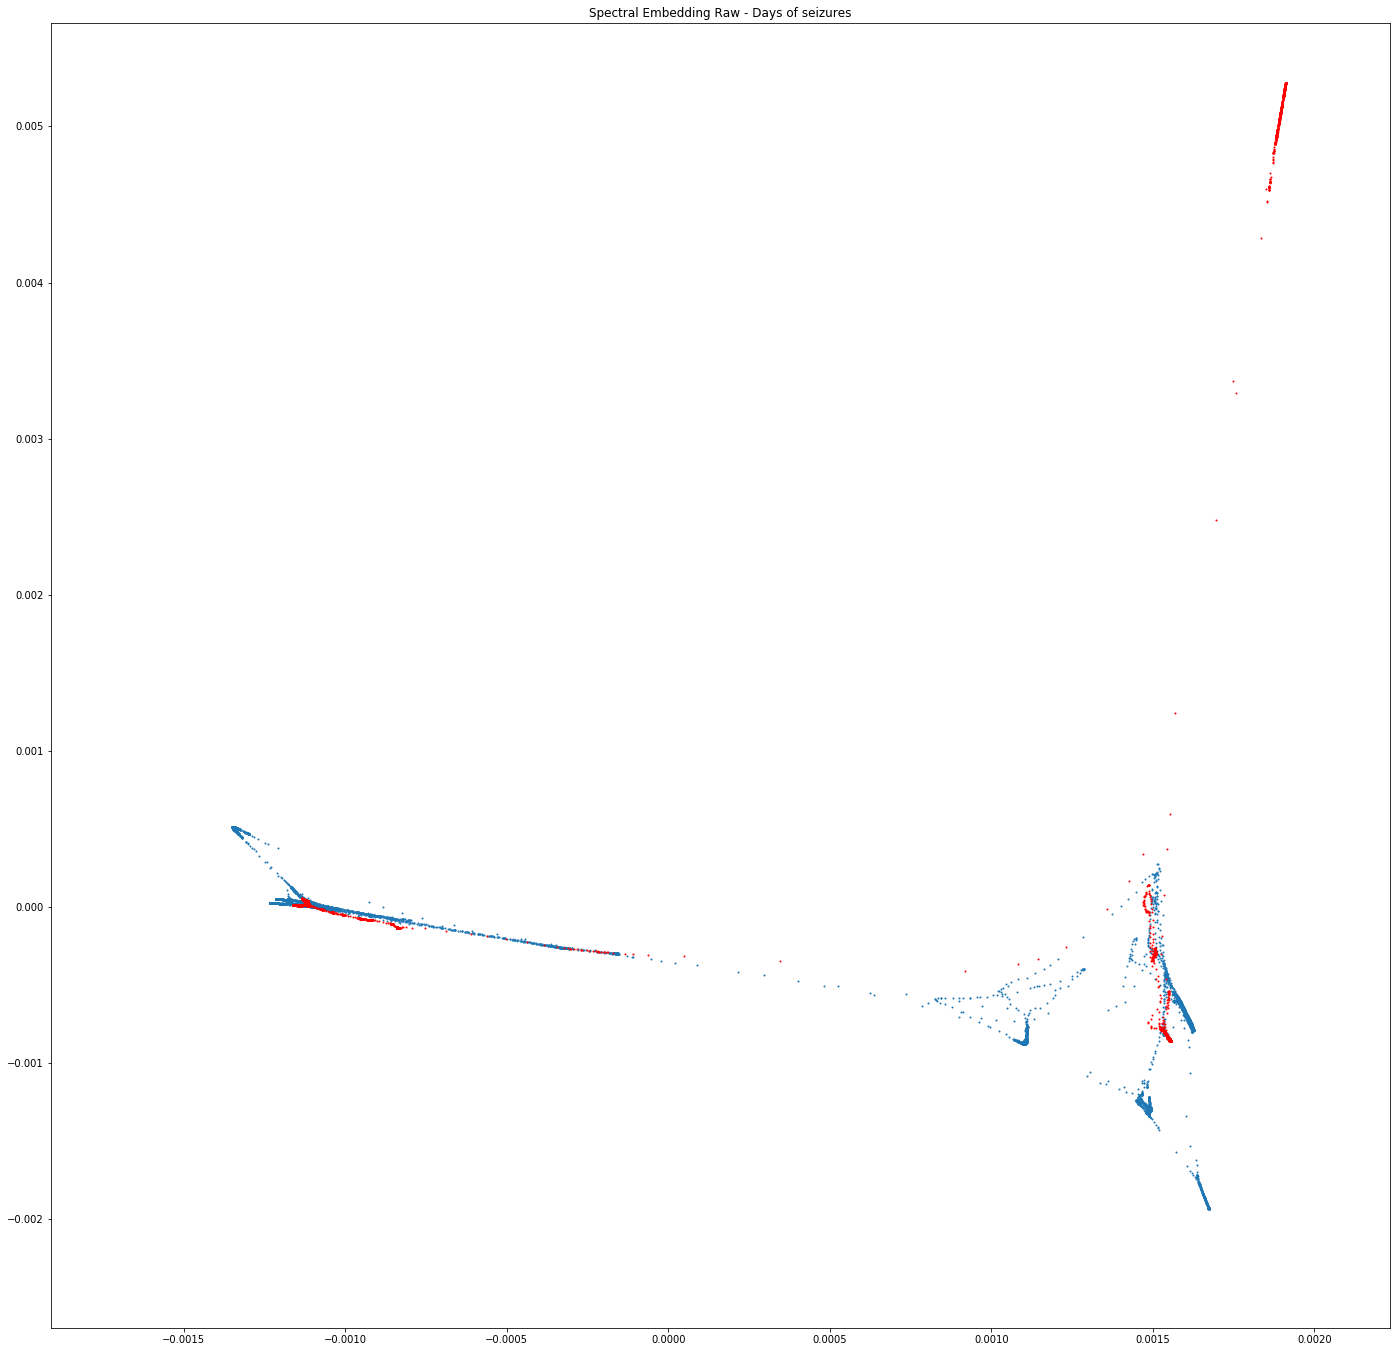

In [18]:
plt.figure(figsize=(24,24))
seSample = seB

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(seSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('Spectral Embedding Raw - Days of seizures')


## t-SNE
*Linea de investigación desechada*

In [ ]:
from tsnecuda import TSNE

### Datos Brutos

In [ ]:
tsneB = TSNE(n_components=2).fit_transform(data)

In [ ]:
plt.figure(figsize=(24,24))
tsneSample = tsneB

target = datosPart['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(tsneSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('t-SNE Raw - Days of seizures')

## MDS

In [17]:
from sklearn.manifold import MDS

### Datos Brutos

In [11]:
mdsB = MDS(n_components=2,max_iter=100).fit_transform(dataPH)

In [14]:
with open('data/MDS-raw-100.npy','wb') as f:
    pk.dump(mdsB,f)

Text(0.5, 1.0, 'MDS Raw - Hour of seizures')

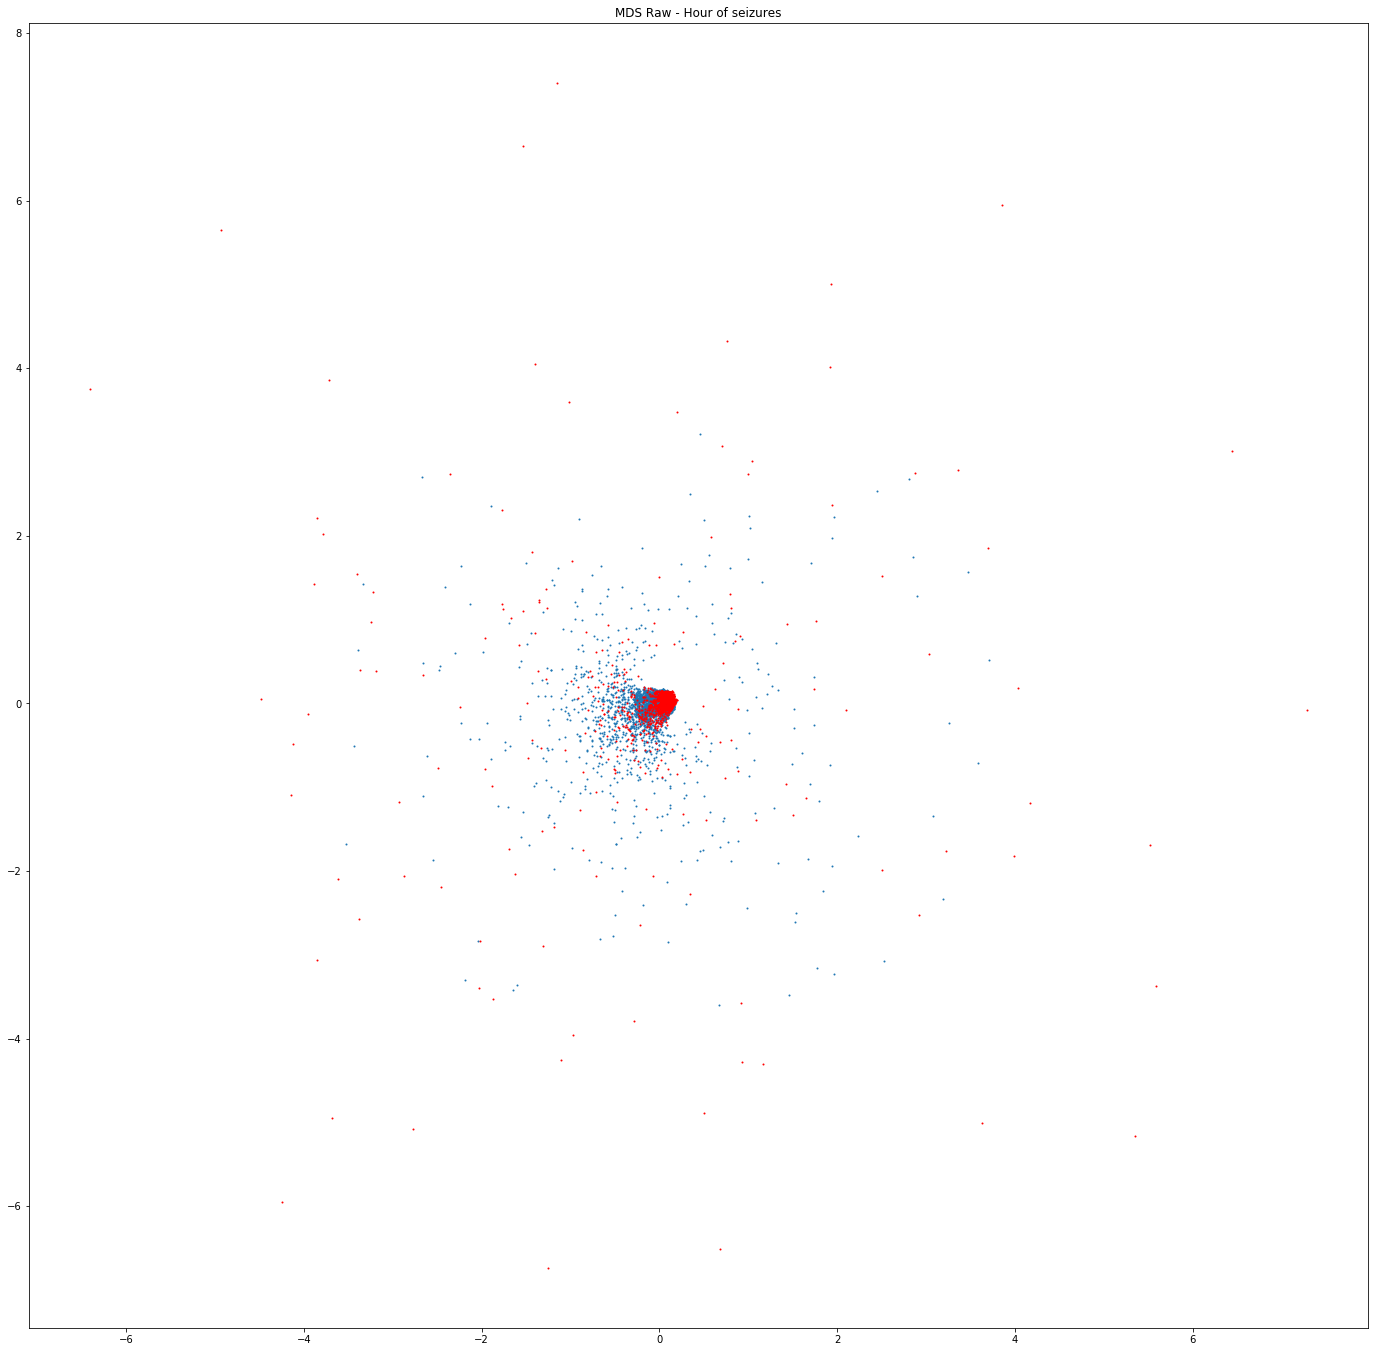

In [26]:
plt.figure(figsize=(24,24))
mdsSample = mdsMean_Std

target = datosPartHour['target'].values
notTarget = np.logical_not(target)

serie = pd.DataFrame(mdsSample)

X = pd.Series(serie[0]).loc[notTarget]
Y = pd.Series(serie[1]).loc[notTarget]

X_t = pd.Series(serie[0]).loc[target]
Y_t = pd.Series(serie[1]).loc[target]

plt.scatter(X,Y,s=1)
plt.scatter(X_t,Y_t,s=1,c='r')
plt.title('MDS Raw - Hour of seizures')

## LTSA

In [14]:
from sklearn.manifold import LocallyLinearEmbedding as LLE

### Datos Brutos

In [13]:
ltsaB = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH)

NameError: name 'LLE' is not defined

In [22]:
with open('data/LTSA-raw-1000.npy','wb') as f:
    pk.dump(ltsaB,f)
plotMin(ltsaB,'LTSA Raw - 1000 Neighbors')

In [18]:
def plotMin(data,title):
    plt.figure(figsize=(24,24))
    sample = data

    target = datosPartHour['target'].values
    notTarget = np.logical_not(target)

    serie = pd.DataFrame(sample)

    X = pd.Series(serie[0]).loc[notTarget]
    Y = pd.Series(serie[1]).loc[notTarget]

    X_t = pd.Series(serie[0]).loc[target]
    Y_t = pd.Series(serie[1]).loc[target]

    plt.scatter(X,Y,s=1)
    plt.scatter(X_t,Y_t,s=1,c='r')
    plt.title(title)

### Datos Estadísticos

In [17]:
ltsaM = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH_mean)

NameError: name 'ltsaSample' is not defined

<Figure size 1728x1728 with 0 Axes>

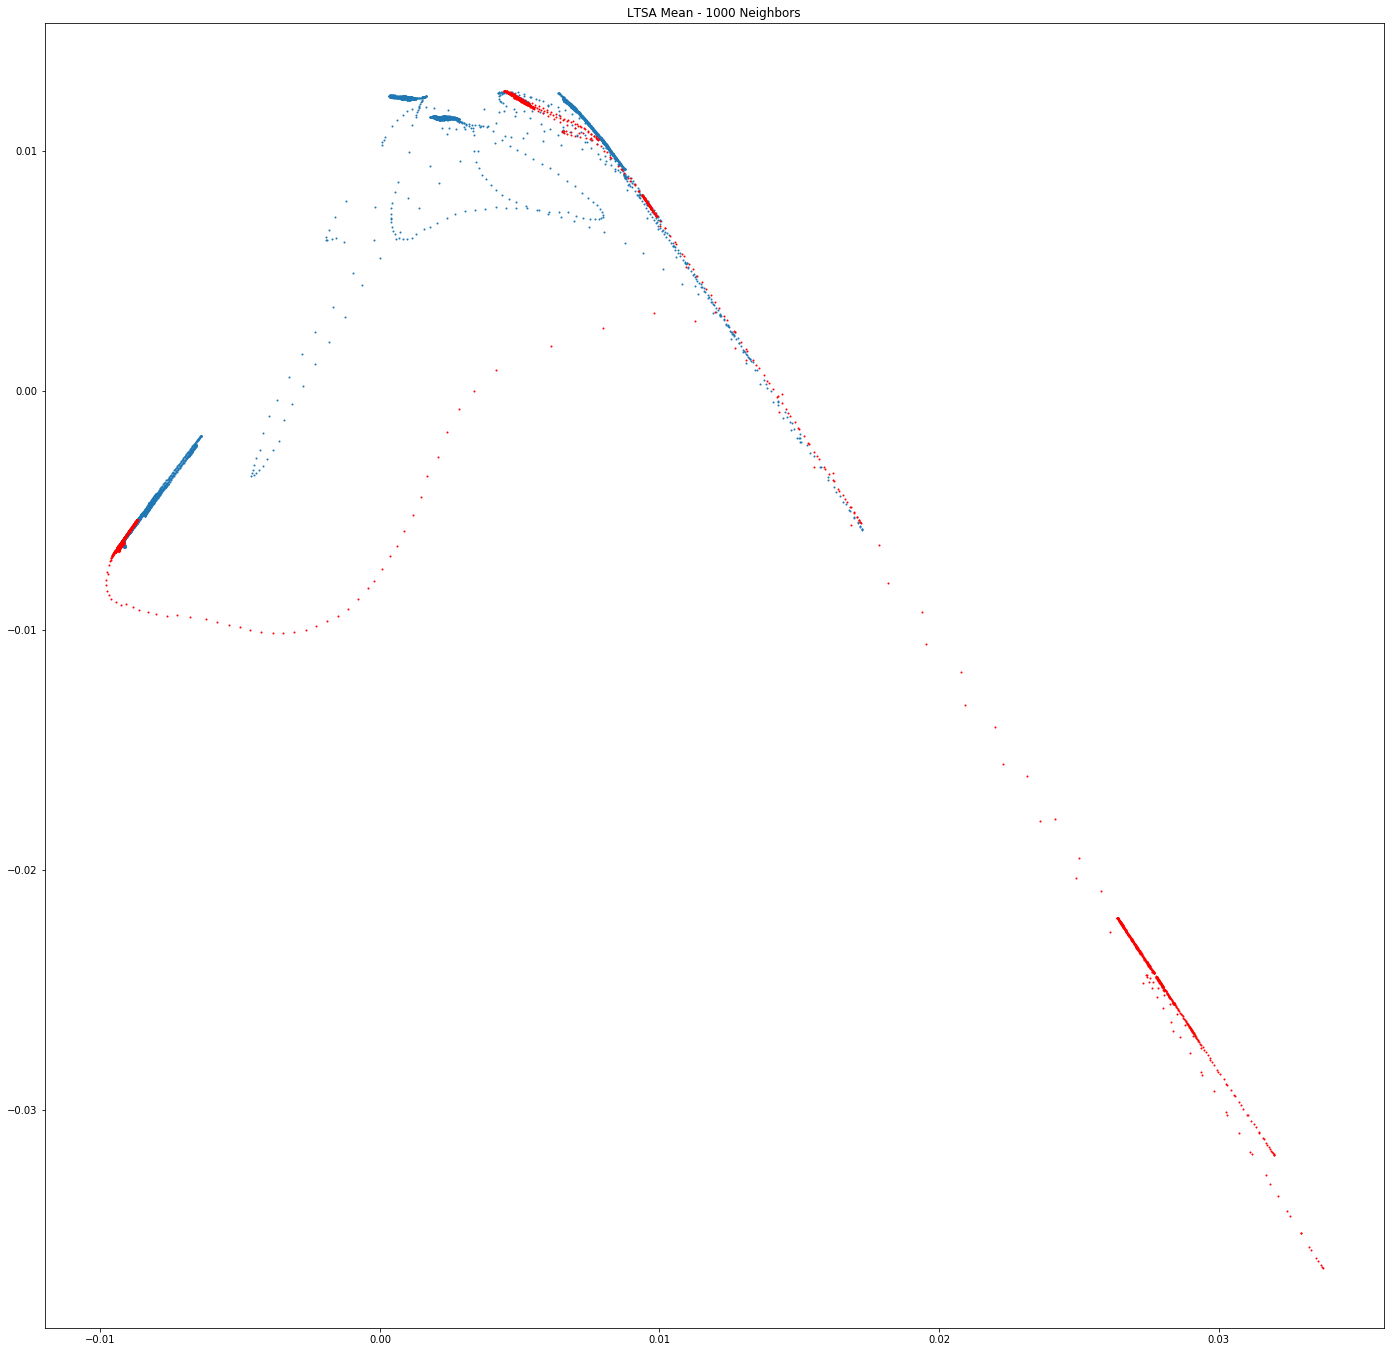

In [19]:
plotMin(ltsaM,'LTSA Mean - 1000 Neighbors')

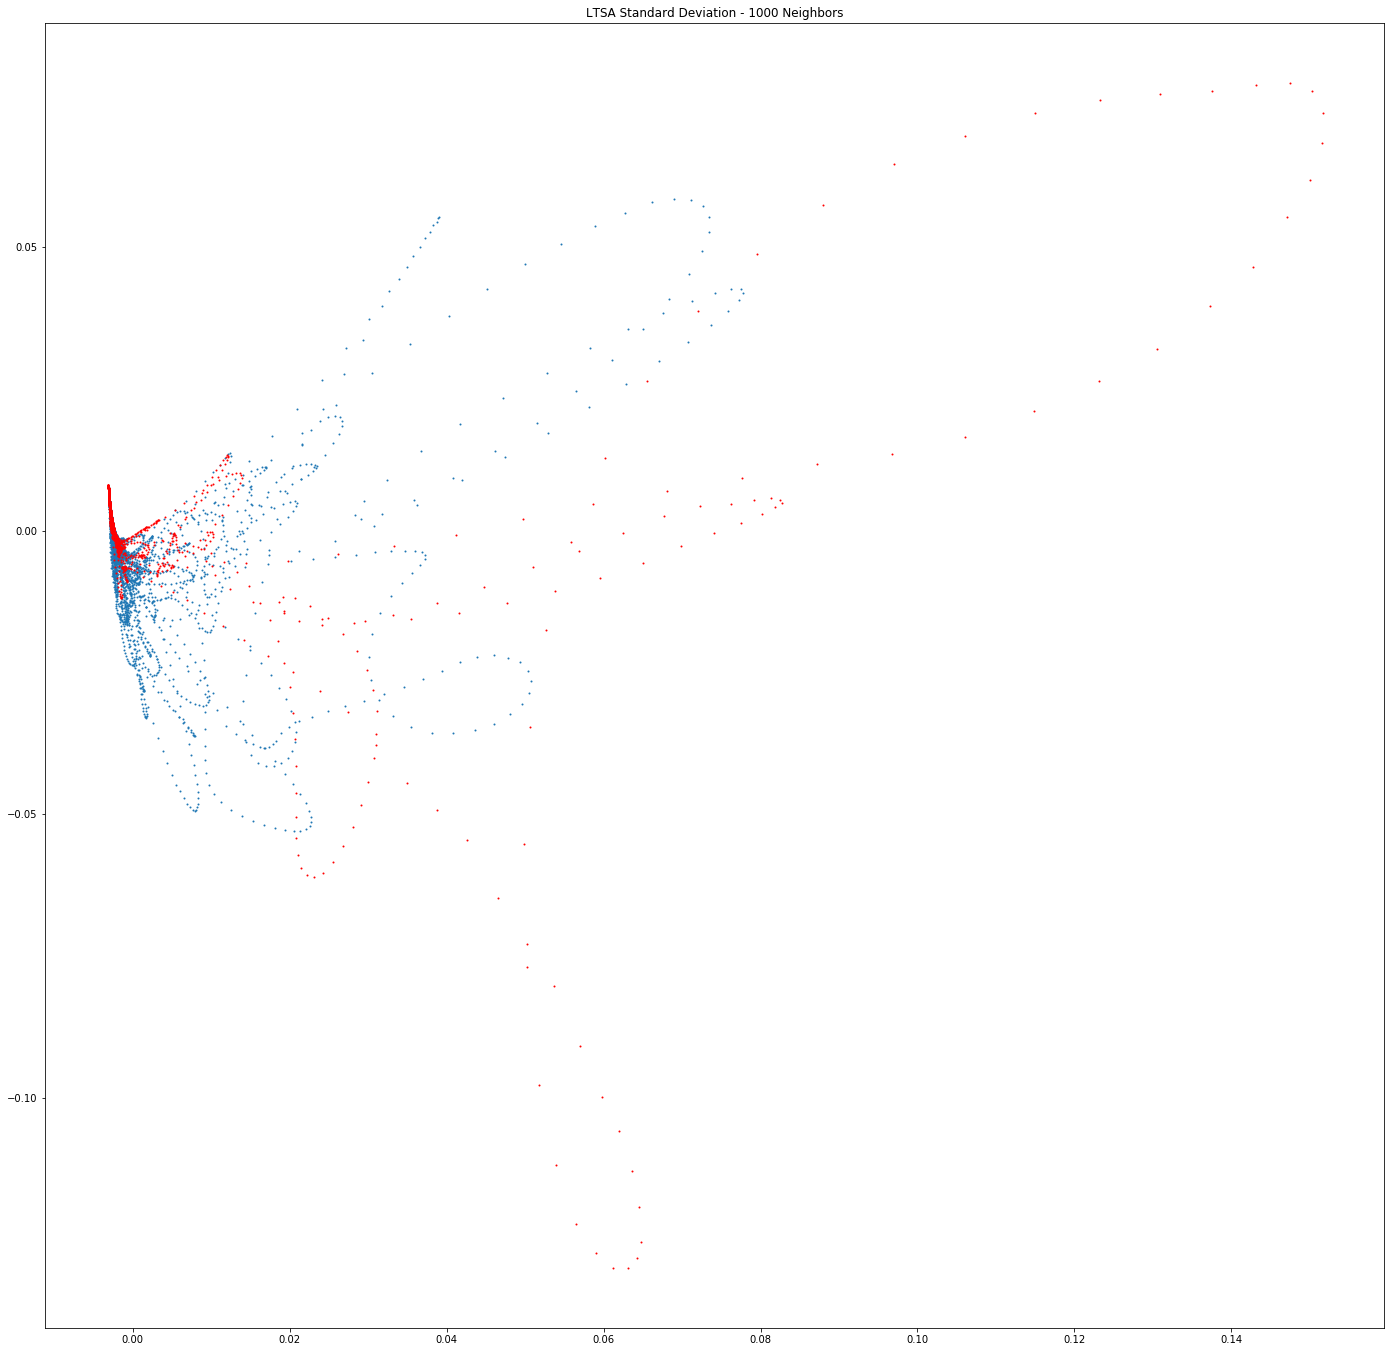

In [20]:
gc.collect()
ltsaD = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH_std)
plotMin(ltsaD,'LTSA Standard Deviation - 1000 Neighbors')

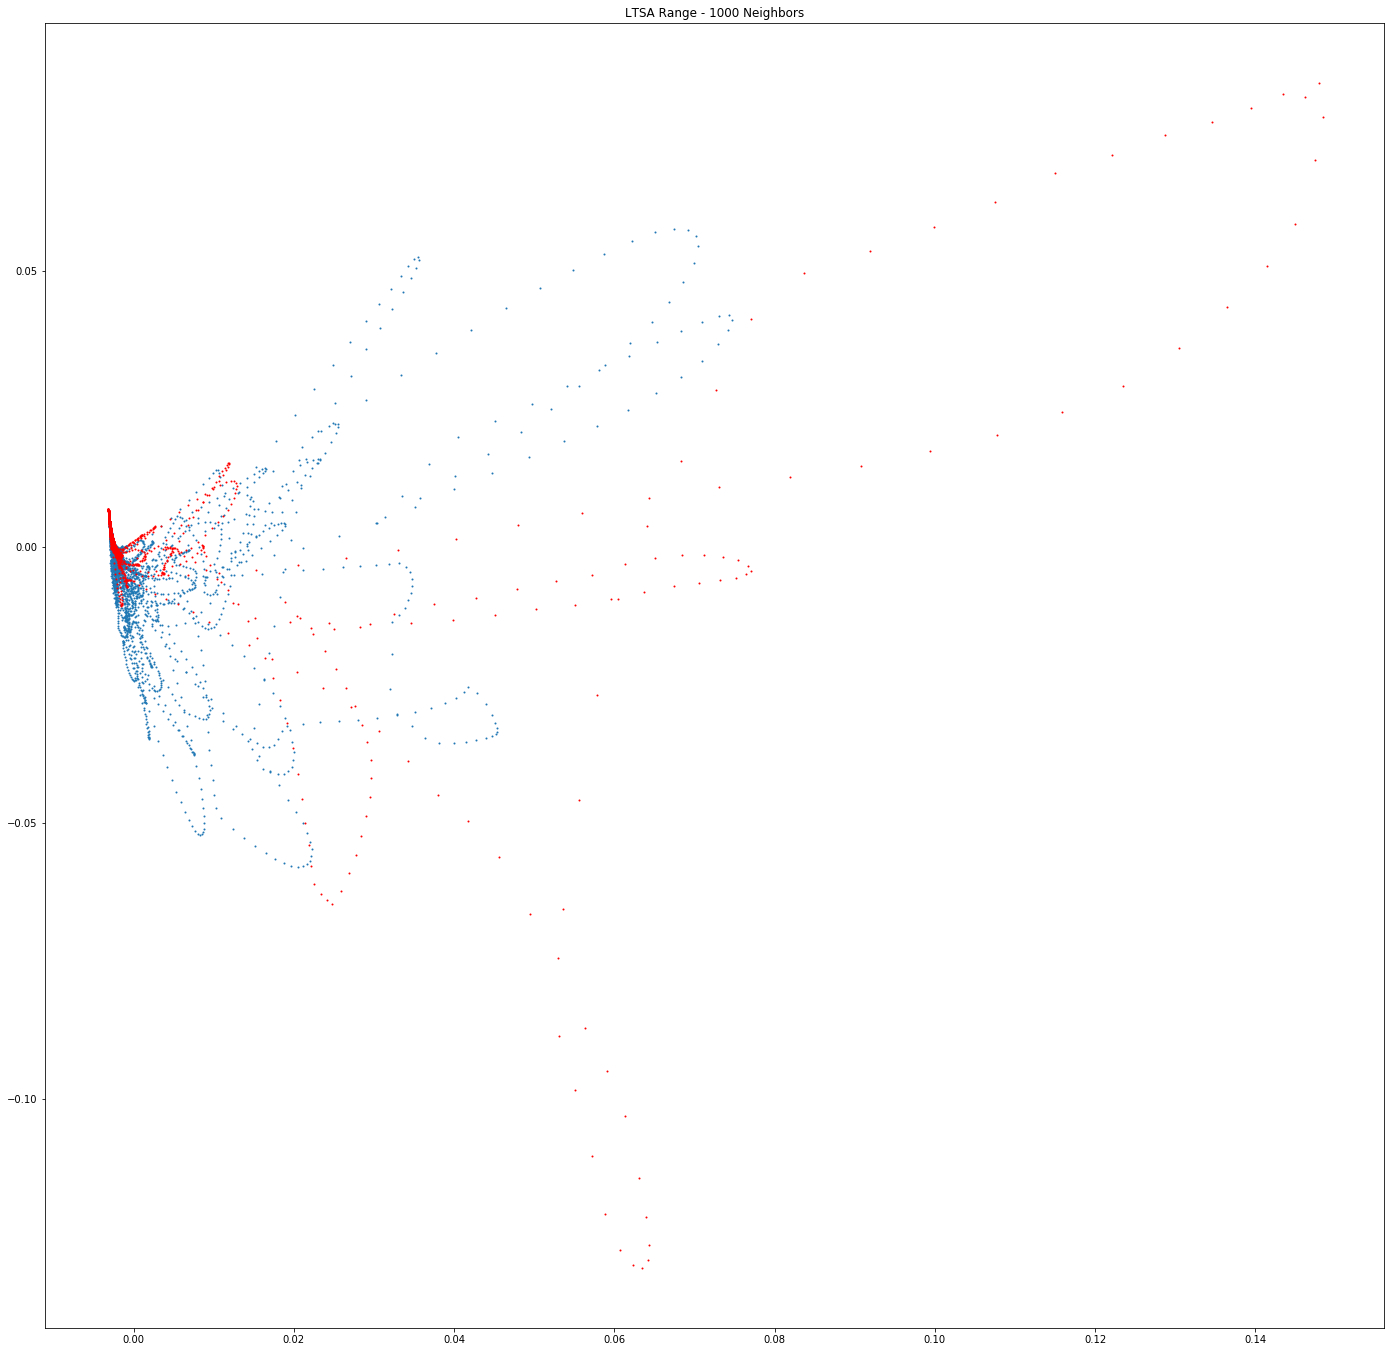

In [ ]:
gc.collect()
ltsaR = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH_range)
plotMin(ltsaR,'LTSA Range - 1000 Neighbors')

In [ ]:
gc.collect()
ltsaMD = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH_mean_std)

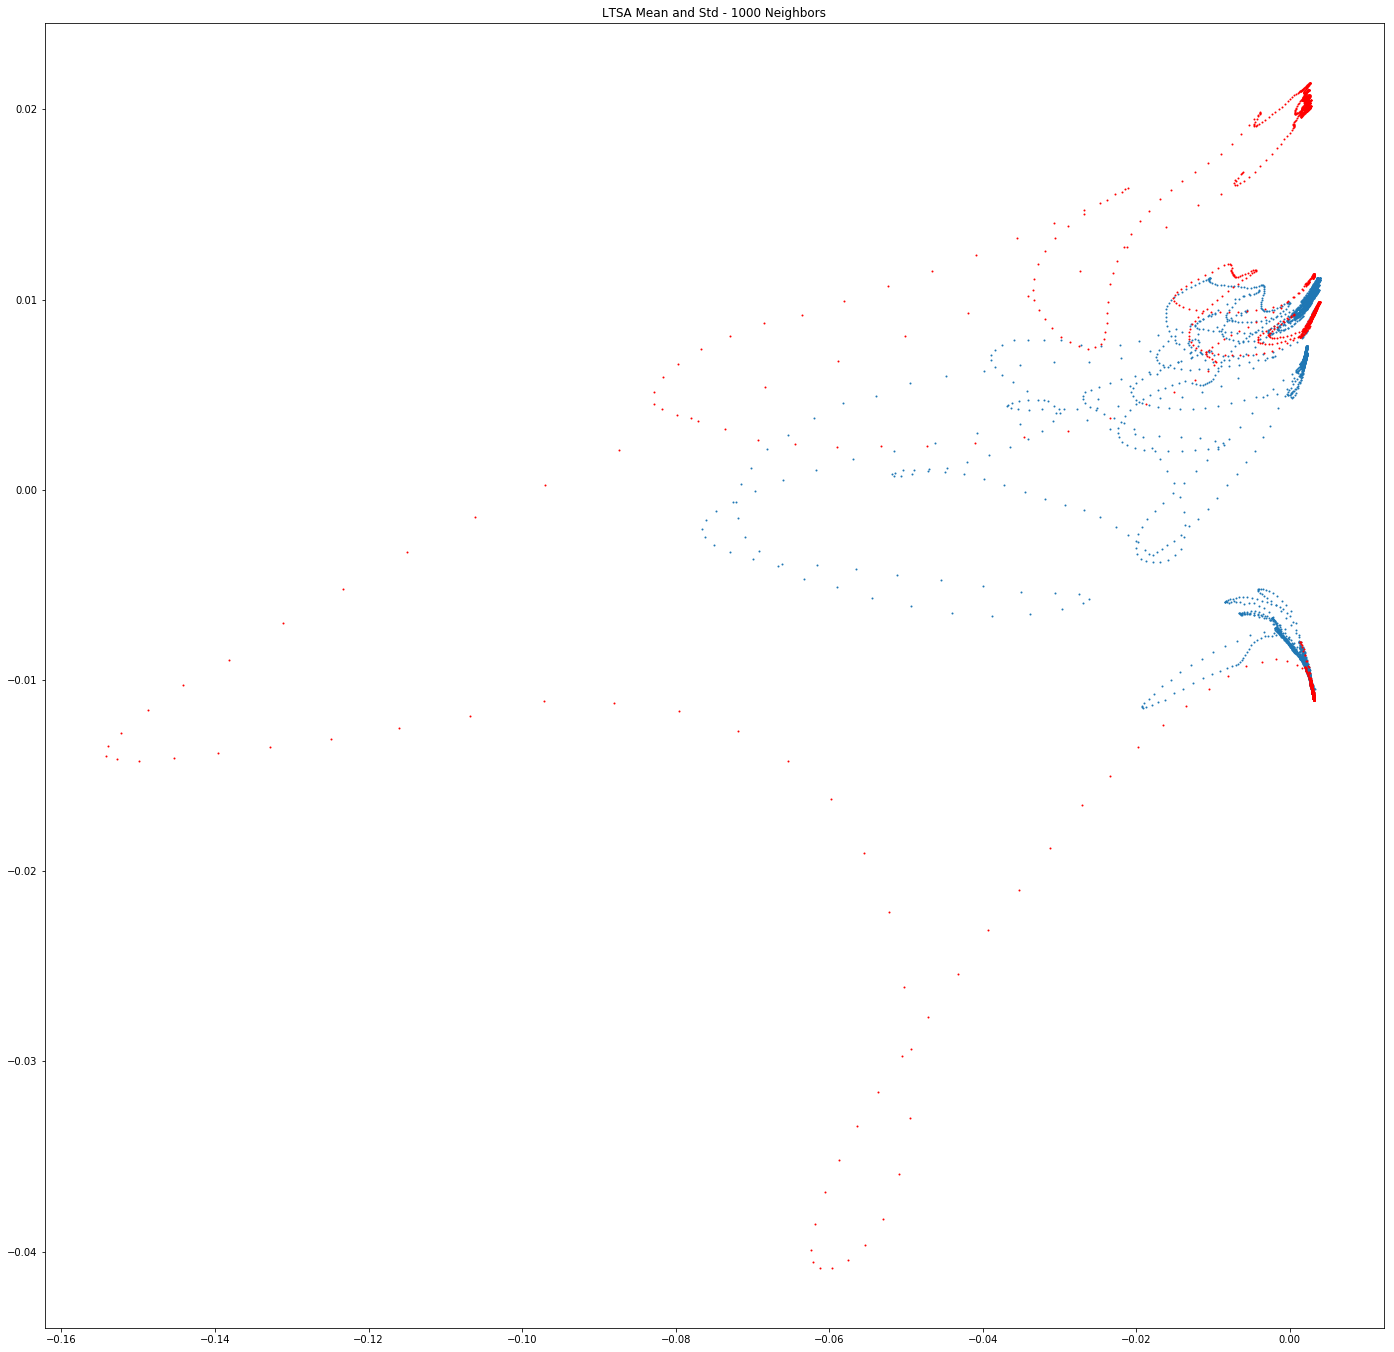

In [25]:
plotMin(ltsaMD,'LTSA Mean and Std - 1000 Neighbors')

In [ ]:
gc.collect()
ltsaE = LLE(n_components=2,method='ltsa',n_neighbors=1000).fit_transform(dataPH)
plotMin(ltsaD,'LTSA Statistical - 1000 Neighbors')